In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
data = pd.HDFStore('data/data.h5','r')
parammat=data['parammat']
targ=data['targ']
data.close()

In [4]:
from sklearn.model_selection import train_test_split
XTraining, XValidation, YTraining, YValidation = train_test_split(parammat,targ,test_size=0.1, shuffle=False) # before model building

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())

2024-06-06 10:58:19.269956: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 10:58:19.326603: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 10:58:19.327698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 10:58:22.216512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
fflds=targ.columns.get_level_values(0)
fdates=targ.columns.get_level_values(1)
flds=targ.columns.get_level_values(0).unique()
dates=targ.columns.get_level_values(1).unique()
nflds=targ.shape[1]
nflds

20

In [6]:
dnn_model=keras.models.load_model('data/dnn_cicero.keras')

In [7]:
X_train = tf.convert_to_tensor(XTraining, dtype=tf.float32)
Y_train = tf.convert_to_tensor(YTraining, dtype=tf.float32)
X_dev = tf.convert_to_tensor(XValidation, dtype=tf.float32)
Y_dev = tf.convert_to_tensor(YValidation, dtype=tf.float32)

In [8]:
pred = dnn_model.predict(X_dev)
pred_t = dnn_model.predict(X_train)

1407/1407 [==============================] - 1s 526us/step


In [9]:
store = pd.HDFStore('data/obs.h5','r')
obs=store['obs']
obsunc=store['obsunc']
store.close()

In [10]:
np.where(targ.std()!=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]),)

In [11]:
use=np.where(((np.isnan(obs)==False).to_numpy())&((targ.std()!=0).to_numpy()))

In [12]:
obsunc.loc['concentrations-CO2']=30
obsunc.loc['OHC700']=40
obsunc.loc['dT_glob']=0.3
obsunc.loc['RIB_glob']=0.35






In [13]:
obsunc

variable            year
dT_glob             1955     0.30
                    1975     0.30
                    1995     0.30
                    2008     0.30
                    2018     0.30
OHC700              1955    40.00
                    1975    40.00
                    1995    40.00
                    2008    40.00
                    2018    40.00
concentrations-CO2  1955    30.00
                    1975    30.00
                    1995    30.00
                    2008    30.00
                    2018    30.00
RIB_glob            1955     0.35
                    1975     0.35
                    1995     0.35
                    2008     0.35
                    2018     0.35
dtype: float64

In [14]:
def skillscore(targ,obs,obsunc,use):
  errm=(((obs.to_numpy()-targ)/obsunc.to_numpy())**2)
  out=-np.sum((errm[:,use[0]]),axis=1)
  return out

In [15]:
skl=skillscore(YTraining.to_numpy(),obs,obsunc,use)

In [16]:
bst=skl.argsort()[-1000:]

In [17]:
bst.shape

(1000,)

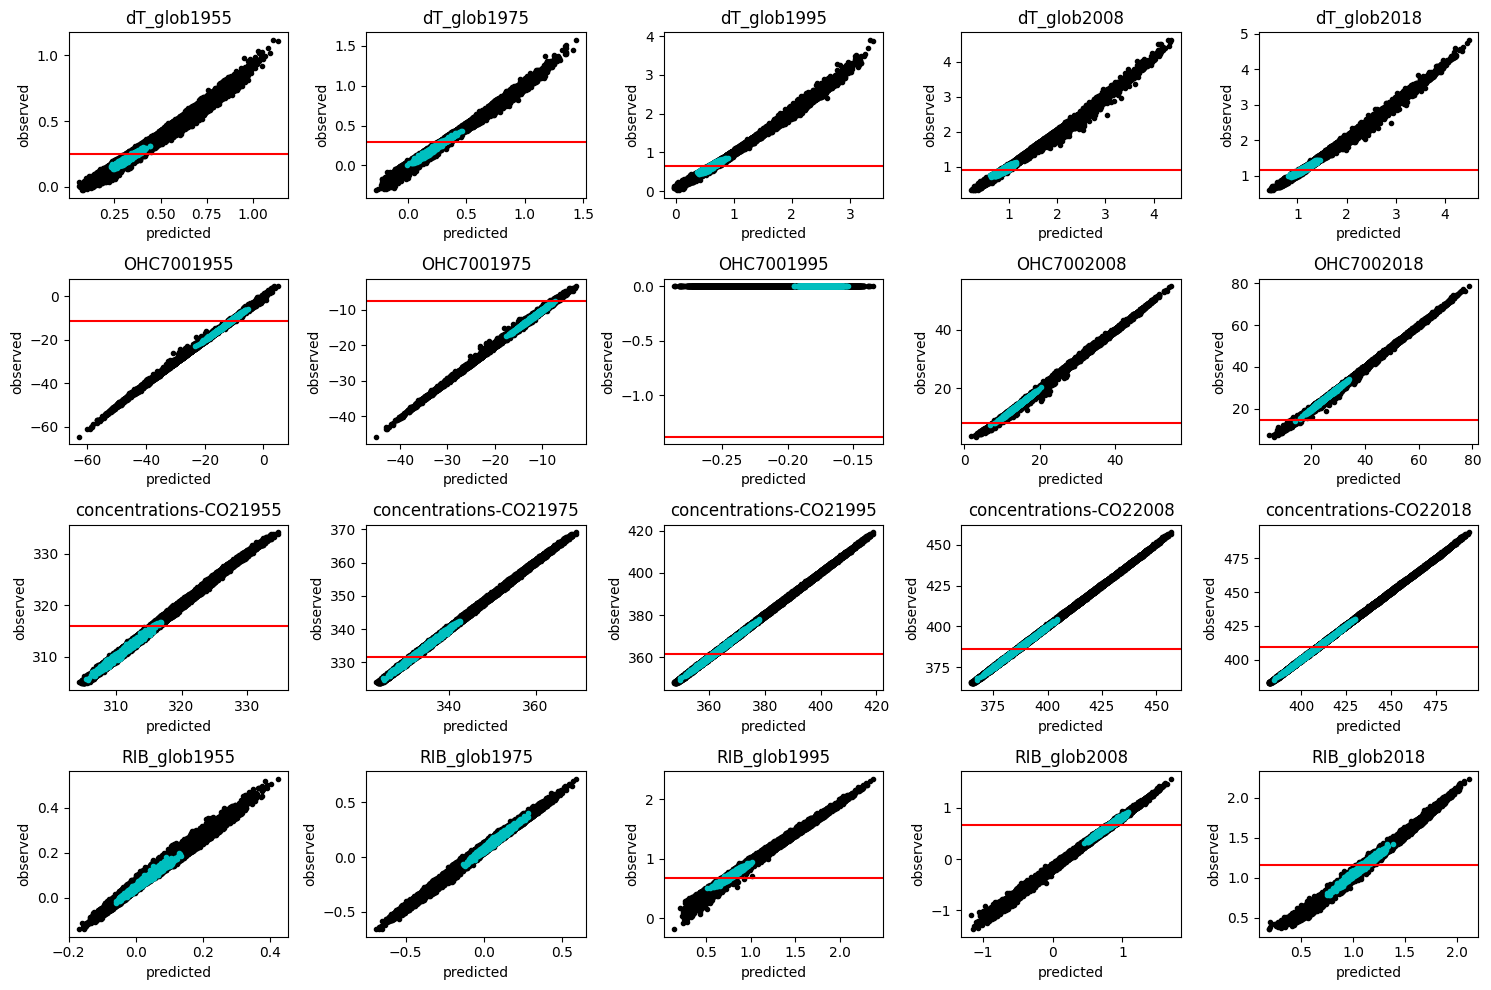

In [18]:
fig, ax = plt.subplots( len(flds), len(dates),figsize=(15, 10))

ax=ax.flatten()
for i in np.arange(nflds):
  ax[i].plot(pred_t[:,i],Y_train[:,i],'.k')
  ax[i].plot(pred_t[bst,i],Y_train.__array__()[bst,i],'.c')
  #ax[i].plot(pred[:,i],Y_dev[:,i],'r.')
  ax[i].set_title(fflds[i]+str(fdates[i]))
  ax[i].set_xlabel('predicted')
  ax[i].set_ylabel('observed')
  ax[i].axhline(obs[i],color='r')
plt.tight_layout()

In [19]:
pmin=XTraining.min()
pmax=XTraining.max()

In [20]:
def log_prob(p,obs,obsunc,use,pmin,pmax):
    ndim=p.shape[1]
    if type(p)!=pd.core.frame.DataFrame:
      p=pd.DataFrame(p)
    if len(p.shape)==1:
      p=p[np.newaxis,:]
    pred=dnn_model.predict(p,verbose = 0)
    out=skillscore(pred,obs,obsunc,use).T
    out[np.isnan(out)]=-5e5
    out[np.abs(out)>5e5]=-5e5
    inrange=(np.vstack([p.iloc[:,i].between(pmin.iloc[i],pmax.iloc[i]).to_numpy() for i in np.arange(ndim)]).sum(axis=0)!=ndim)*1e10
    out=out-inrange
    return out

In [21]:
predskl=log_prob(XTraining,obs,obsunc,use,pmin,pmax)

In [22]:
predskl

array([-20.97862652, -34.57388027,  -1.01700723, ..., -53.93920434,
        -7.61772662,  -1.79852041])

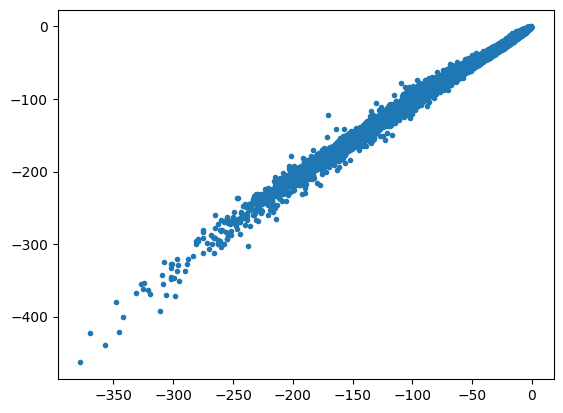

In [23]:
plt.plot(predskl,skl,'.')

In [24]:
import emcee


In [25]:
ndim=parammat.shape[1]


In [26]:


 nwalkers = len(bst)
ivar = 1. / np.random.rand(ndim)
p0 = X_train.__array__()[bst,:]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[obs,obsunc,use,pmin,pmax],vectorize=True)
sampler.run_mcmc(p0, 2000,progress=True)

100%|██████████| 2000/2000 [09:09<00:00,  3.64it/s]


State([[6.5041137e+00 5.8460802e-01 4.6674109e-01 ... 8.5339905e+01
  3.0438265e-01 8.9837275e-02]
 [1.4745029e+01 5.0340694e-01 5.6497091e-01 ... 7.3062508e+01
  1.8493348e-01 9.9667922e-02]
 [1.2227428e+01 4.4054896e-01 2.1392480e-01 ... 7.1431908e+01
  5.4831052e-01 8.0382682e-02]
 ...
 [5.2827768e+00 6.4916080e-01 1.6204637e-01 ... 7.6813965e+01
  4.3500799e-01 8.5168958e-02]
 [7.6054258e+00 7.9182762e-01 4.6393692e-01 ... 3.1220037e+01
  2.7574252e-02 9.4975971e-02]
 [1.2840130e+01 6.4004129e-01 3.6825657e-01 ... 7.1945641e+01
  2.5716358e-01 8.9153685e-02]], log_prob=[-1.96745778 -3.08048535 -2.48476609 -1.86663557 -1.10494236 -1.75045861
 -1.25171668 -2.74194286 -0.93221978 -1.0595716  -2.93182945 -1.8291816
 -1.09108655 -1.52254259 -2.18687711 -3.09495367 -1.08076619 -4.76902093
 -6.08533666 -2.55847847 -1.75202786 -2.10152057 -0.86424919 -1.7705747
 -1.82608489 -2.18725256 -0.65098233 -1.91308157 -1.5010135  -2.55998067
 -1.53089933 -2.00803412 -1.57467922 -1.19689064 -2.44481

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
         1.,  1.,  0.,  1.,  1.,  3.,  0.,  3.,  2.,  1.,  1.,  2.,  0.,
         3.,  4.,  2.,  4.,  3.,  1.,  2.,  2.,  4.,  2.,  5.,  6.,  6.,
         4.,  5.,  7.,  9.,  9., 11.,  4., 15., 10.,  8., 13.,  7.,  3.,
        10., 26., 18., 11., 19., 21., 20., 22., 24., 22., 26., 18., 30.,
        19., 28., 27., 23., 27., 36., 33., 27., 29., 30., 31., 40., 27.,
        38., 25., 26., 16., 22., 28., 13.,  7.,  9.]),
 array([-6.8700221 , -6.8067963 , -6.7435705 , -6.68034471, -6.61711891,
        -6.55389311, -6.49066731, -6.42744152, -6.36421572, -6.30098992,
        -6.23776413, -6.17453833, -6.11131253, -6.04808673, -5.98486094,
        -5.92163514, -5.85840934, -5.79518355, -5.73195775, -5.66873195,
        -5.60550615, -5.54228036, -5.47905456, -5.41582876, -5.35260297,
        -5.28937717, -5.22615137, -5.16292557, -5.09969978, -5.036473

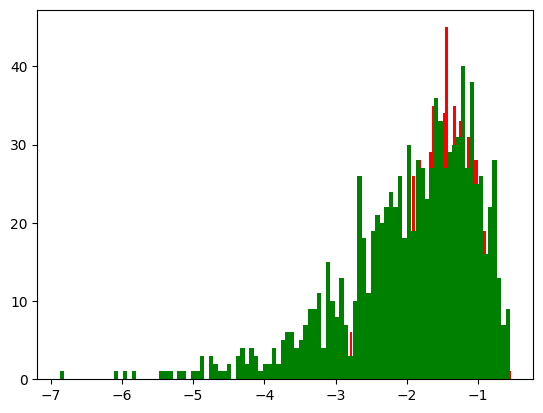

In [27]:
plt.hist(log_prob(p0,obs,obsunc,use,pmin,pmax),100,color='r')
plt.hist(log_prob(np.vstack(sampler.chain[:,-1:,:]),obs,obsunc,use,pmin,pmax),100,color='g')

In [28]:
opt=pd.DataFrame(sampler.chain[:,-1:,:].squeeze(),columns=parammat.columns)

In [29]:
opt.head()

,rlamdo,akapa,cpi,W,beto,lambda,mixed,qo3,qdirso2,qindso2,qbc,qoc,beta_f,mixed_carbon,qbmb,qh2o_ch4
0,6.504114,0.584608,0.466741,1.415648,3.661635,0.742021,94.178558,0.435953,-0.395697,-0.810603,0.172177,-0.089050,0.184022,85.339905,0.304383,0.089837
1,14.745029,0.503407,0.564971,0.946923,1.616327,0.739344,95.238937,0.567056,-0.330624,-0.867897,0.120229,-0.088090,0.230864,73.062508,0.184933,0.099668
2,12.227428,0.440549,0.213925,1.353085,6.115185,0.645151,40.805717,0.590828,-0.473528,-0.819371,0.120193,-0.092662,0.436853,71.431908,0.548311,0.080383
3,15.631832,0.635912,0.184013,1.022443,4.947063,0.661812,88.209778,0.460281,-0.278123,-0.813813,0.113888,-0.074046,0.376763,100.292381,0.056262,0.098162
4,21.043171,0.454042,0.272120,2.457716,1.168632,0.652604,62.025856,0.487628,-0.260609,-0.743368,0.137408,-0.065835,0.404308,88.725357,0.046330,0.094898


In [30]:
store = pd.HDFStore('data/optparam.h5')
store['opt'] = opt
store.close()